In [ ]:
%pip install pyspark
%pip install seaborn
%pip install seaborn matplotlib pandas numpy

In [2]:
# imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import split, col, count, when, sum, expr, udf
from pyspark.sql.types import FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from google.colab import files

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NetTraffic").getOrCreate()
spark.sparkContext.setLogLevel("INFO")

print("✅ Spark is running!")


✅ Spark is running!


In [ ]:
# Path to the file (same folder as notebook)
file_path = "dataset_malware.csv"

# Load the CSV into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True, sep="|")

# Show first 5 rows
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|                 ts|               uid|    id.orig_h|id.orig_p|     id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|      -|3.097754|         0|         0|        S0|      

# Exploratory Data Analysis

'''
ts -> timestamp (all unique)
uid -> unique identifier (all unique)
id.orig_h -> source of IP address
id.orig_p -> source port
id.resp_h -> destn IP address
id.resp_p -> destn port
proto -> network protocol
service -> service used for connection
duration -> duration of connection

orig_bytes -> bytes sent from source to destn (aka data transferred)
resp_bytes -> bytes sent from destn to source (aka data transferred)
conn_state -> state of connection
local_orig -> connection local?
local_resp -> connection local?
missed_bytes -> missed bytes in connection
history -> connection states history

orig_pkts -> packets sent from source to destn
orig_ip_bytes -> IP bytes sent from source to destn (aka data transferred + IP protocols)
resp_pkts -> packets sent from destn to source
resp_ip_bytes -> IP bytes sent from destn to source (aka data transferred + IP protocols)
tunnell_parents -> connection part of tunnel
label -> connection type (all have labels)
detailed-label -> connection type

only duration & orig_bytes have (1) null value -> Can drop row
[Bytes are a key variable to look out for] -> large bytes are rare, could be malicious
[IP Bytes are another variable] -> If IP bytes - bytes is big, could show malicious attacks
[Packets are another variable] -> Packet to byte ratio could show malicious attacks
[If multiple ]
'''

## Display first 5 rows in dataset

In [9]:
# print(df_split.head())
# Show first 5 rows
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|                 ts|               uid|    id.orig_h|id.orig_p|     id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|      -|3.097754|         0|         0|        S0|      

## Show schema to identify column types

In [10]:
df.printSchema()

root
 |-- ts: double (nullable = true)
 |-- uid: string (nullable = true)
 |-- id.orig_h: string (nullable = true)
 |-- id.orig_p: double (nullable = true)
 |-- id.resp_h: string (nullable = true)
 |-- id.resp_p: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- orig_bytes: string (nullable = true)
 |-- resp_bytes: string (nullable = true)
 |-- conn_state: string (nullable = true)
 |-- local_orig: string (nullable = true)
 |-- local_resp: string (nullable = true)
 |-- missed_bytes: double (nullable = true)
 |-- history: string (nullable = true)
 |-- orig_pkts: double (nullable = true)
 |-- orig_ip_bytes: double (nullable = true)
 |-- resp_pkts: double (nullable = true)
 |-- resp_ip_bytes: double (nullable = true)
 |-- tunnel_parents: string (nullable = true)
 |-- label: string (nullable = true)
 |-- detailed-label: string (nullable = true)



- Cast '-' to NaN
- change column names so that Spark will not misinterpret them

In [11]:
for column in df.columns:
    df = df.withColumn(column, when(col(f"`{column}`") == "-", None).otherwise(col(f"`{column}`")))

# Rename columns to replace dots with underscores
new_column_names = [c.replace(".", "_") for c in df.columns]
df = df.toDF(*new_column_names)

# Check
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|                 ts|               uid|    id_orig_h|id_orig_p|     id_resp_h|id_resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|   NULL|3.097754|         0|         0|        S0|      

## Show number of NA values

In [19]:
# print(df_split.isnull().sum())
null_values = (
    df.select([
        sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ])
    .toPandas()
    .T.rename(columns={0: "Count"})
)

display(null_values)

,Count
ts,0
uid,0
id_orig_h,0
id_orig_p,0
id_resp_h,0
id_resp_p,0
proto,0
duration,4432615
orig_bytes,4432615
resp_bytes,4432615


Drop NA values

In [36]:

from pyspark.sql.functions import when, col

# Columns you care about
columns_to_clean = ['duration', 'orig_bytes', 'resp_bytes']

# Replace "NULL" or "null" strings with actual nulls (None)
for c in columns_to_clean:
    df = df.withColumn(c, when((col(c) == "NULL") | (col(c) == "null"), None).otherwise(col(c)))

# Now drop rows where any of these are null
df = df.dropna(subset=columns_to_clean)

from pyspark.sql.functions import col, sum as spark_sum

null_values = (
    df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in df_cleaned.columns
    ])
    .toPandas()
    .T.rename(columns={0: "Count"})
)

display(null_values)

,Count
ts,0
uid,0
id_orig_h,0
id_orig_p,0
id_resp_h,0
id_resp_p,0
proto,0
duration,0
orig_bytes,0
resp_bytes,0


## Convert relevant columns into numerical datatypes

In [31]:
cols_to_convert = [
    "id_orig_p", "id_resp_p", "duration", "orig_bytes", "resp_bytes",
    "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]

# convert columns to float type
for column in cols_to_convert:
    df = df.withColumn(column, col(column).cast(FloatType()))

# display descriptive statistics (using Pandas for clearer transposed version)
desc_stats = df.describe(cols_to_convert)
desc_stats_pd = desc_stats.toPandas()
desc_stats_pd = desc_stats_pd.set_index('summary')
desc_stats_transposed = desc_stats_pd.T
display(desc_stats_transposed)


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `missed_bytes` cannot be resolved. Did you mean one of the following? [`resp_bytes`, `orig_bytes`, `orig_ip_bytes`, `resp_ip_bytes`, `resp_pkts`].;
'Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3266, orig_bytes#3285, resp_bytes#3304, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, cast('missed_bytes as float) AS missed_bytes#3323]
+- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3266, orig_bytes#3285, cast(resp_bytes#3208 as float) AS resp_bytes#3304, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
   +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3266, cast(orig_bytes#3189 as float) AS orig_bytes#3285, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
      +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, cast(duration#3170 as float) AS duration#3266, orig_bytes#3189, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
         +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, cast(id_resp_p#3151 as float) AS id_resp_p#3247, proto#854, duration#3170, orig_bytes#3189, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
            +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#3132 as float) AS id_orig_p#3228, id_resp_h#852, id_resp_p#3151, proto#854, duration#3170, orig_bytes#3189, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
               +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, id_resp_p#3151, proto#854, duration#3170, orig_bytes#3189, cast(resp_bytes#2951 as float) AS resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                  +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, id_resp_p#3151, proto#854, duration#3170, cast(orig_bytes#2932 as float) AS orig_bytes#3189, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                     +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, id_resp_p#3151, proto#854, cast(duration#2913 as float) AS duration#3170, orig_bytes#2932, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                        +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, cast(id_resp_p#2653 as float) AS id_resp_p#3151, proto#854, duration#2913, orig_bytes#2932, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                           +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#2634 as float) AS id_orig_p#3132, id_resp_h#852, id_resp_p#2653, proto#854, duration#2913, orig_bytes#2932, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2913, orig_bytes#2932, CASE WHEN ((resp_bytes#2876 = cast(NULL as float)) OR (resp_bytes#2876 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#2876 END AS resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                 +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2913, CASE WHEN ((orig_bytes#2857 = cast(NULL as float)) OR (orig_bytes#2857 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#2857 END AS orig_bytes#2932, resp_bytes#2876, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                    +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, CASE WHEN ((duration#2838 = cast(NULL as float)) OR (duration#2838 = cast(null as float))) THEN cast(null as float) ELSE duration#2838 END AS duration#2913, orig_bytes#2857, resp_bytes#2876, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                       +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2838, orig_bytes#2857, CASE WHEN ((resp_bytes#2710 = cast(NULL as float)) OR (resp_bytes#2710 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#2710 END AS resp_bytes#2876, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                          +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2838, CASE WHEN ((orig_bytes#2691 = cast(NULL as float)) OR (orig_bytes#2691 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#2691 END AS orig_bytes#2857, resp_bytes#2710, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                             +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, CASE WHEN ((duration#2672 = cast(NULL as float)) OR (duration#2672 = cast(null as float))) THEN cast(null as float) ELSE duration#2672 END AS duration#2838, orig_bytes#2691, resp_bytes#2710, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2672, orig_bytes#2691, cast(resp_bytes#2614 as float) AS resp_bytes#2710, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                   +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2672, cast(orig_bytes#2595 as float) AS orig_bytes#2691, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                      +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, cast(duration#2576 as float) AS duration#2672, orig_bytes#2595, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                         +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, cast(id_resp_p#1034 as float) AS id_resp_p#2653, proto#854, duration#2576, orig_bytes#2595, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                            +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#1010 as float) AS id_orig_p#2634, id_resp_h#852, id_resp_p#1034, proto#854, duration#2576, orig_bytes#2595, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                               +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, duration#2576, orig_bytes#2595, cast(resp_bytes#1106 as float) AS resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                                  +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, duration#2576, cast(orig_bytes#1082 as float) AS orig_bytes#2595, resp_bytes#1106, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                                     +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, cast(duration#1058 as float) AS duration#2576, orig_bytes#1082, resp_bytes#1106, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                                        +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                                                                           +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, cast(resp_ip_bytes#867 as float) AS resp_ip_bytes#1226, tunnel_parents#868, label#869, detailed-label#870]
                                                                              +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, orig_pkts#1154, orig_ip_bytes#1178, cast(resp_pkts#866 as float) AS resp_pkts#1202, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                 +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, orig_pkts#1154, cast(orig_ip_bytes#865 as float) AS orig_ip_bytes#1178, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                    +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, cast(orig_pkts#864 as float) AS orig_pkts#1154, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                       +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, cast(missed_bytes#862 as float) AS missed_bytes#1130, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                          +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, cast(resp_bytes#858 as float) AS resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                             +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, cast(orig_bytes#857 as float) AS orig_bytes#1082, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                                +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, cast(duration#856 as float) AS duration#1058, orig_bytes#857, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                                   +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, cast(id_resp_p#853 as float) AS id_resp_p#1034, proto#854, service#855, duration#856, orig_bytes#857, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                                      +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#851 as float) AS id_orig_p#1010, id_resp_h#852, id_resp_p#853, proto#854, service#855, duration#856, orig_bytes#857, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                                                                                                         +- Project [ts#296 AS ts#848, uid#320 AS uid#849, id.orig_h#344 AS id_orig_h#850, id.orig_p#368 AS id_orig_p#851, id.resp_h#392 AS id_resp_h#852, id.resp_p#416 AS id_resp_p#853, proto#440 AS proto#854, service#464 AS service#855, duration#488 AS duration#856, orig_bytes#512 AS orig_bytes#857, resp_bytes#536 AS resp_bytes#858, conn_state#560 AS conn_state#859, local_orig#584 AS local_orig#860, local_resp#608 AS local_resp#861, missed_bytes#632 AS missed_bytes#862, history#656 AS history#863, orig_pkts#680 AS orig_pkts#864, orig_ip_bytes#704 AS orig_ip_bytes#865, resp_pkts#728 AS resp_pkts#866, resp_ip_bytes#752 AS resp_ip_bytes#867, tunnel_parents#776 AS tunnel_parents#868, label#800 AS label#869, detailed-label#824 AS detailed-label#870]
                                                                                                            +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, tunnel_parents#776, label#800, CASE WHEN (detailed-label#39 = -) THEN cast(null as string) ELSE detailed-label#39 END AS detailed-label#824]
                                                                                                               +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, tunnel_parents#776, CASE WHEN (label#38 = -) THEN cast(null as string) ELSE label#38 END AS label#800, detailed-label#39]
                                                                                                                  +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, CASE WHEN (tunnel_parents#37 = -) THEN cast(null as string) ELSE tunnel_parents#37 END AS tunnel_parents#776, label#38, detailed-label#39]
                                                                                                                     +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, CASE WHEN (resp_ip_bytes#36 = cast(- as double)) THEN cast(null as double) ELSE resp_ip_bytes#36 END AS resp_ip_bytes#752, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                        +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, CASE WHEN (resp_pkts#35 = cast(- as double)) THEN cast(null as double) ELSE resp_pkts#35 END AS resp_pkts#728, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                           +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, CASE WHEN (orig_ip_bytes#34 = cast(- as double)) THEN cast(null as double) ELSE orig_ip_bytes#34 END AS orig_ip_bytes#704, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                              +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, CASE WHEN (orig_pkts#33 = cast(- as double)) THEN cast(null as double) ELSE orig_pkts#33 END AS orig_pkts#680, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                 +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, CASE WHEN (history#32 = -) THEN cast(null as string) ELSE history#32 END AS history#656, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                    +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, CASE WHEN (missed_bytes#31 = cast(- as double)) THEN cast(null as double) ELSE missed_bytes#31 END AS missed_bytes#632, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                       +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, CASE WHEN (local_resp#30 = -) THEN cast(null as string) ELSE local_resp#30 END AS local_resp#608, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                          +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, CASE WHEN (local_orig#29 = -) THEN cast(null as string) ELSE local_orig#29 END AS local_orig#584, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                             +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, CASE WHEN (conn_state#28 = -) THEN cast(null as string) ELSE conn_state#28 END AS conn_state#560, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, CASE WHEN (resp_bytes#27 = -) THEN cast(null as string) ELSE resp_bytes#27 END AS resp_bytes#536, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                   +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, CASE WHEN (orig_bytes#26 = -) THEN cast(null as string) ELSE orig_bytes#26 END AS orig_bytes#512, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                      +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, CASE WHEN (duration#25 = -) THEN cast(null as string) ELSE duration#25 END AS duration#488, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                         +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, CASE WHEN (service#24 = -) THEN cast(null as string) ELSE service#24 END AS service#464, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                            +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, CASE WHEN (proto#23 = -) THEN cast(null as string) ELSE proto#23 END AS proto#440, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                               +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, CASE WHEN (id.resp_p#22 = cast(- as double)) THEN cast(null as double) ELSE id.resp_p#22 END AS id.resp_p#416, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                                  +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, CASE WHEN (id.resp_h#21 = -) THEN cast(null as string) ELSE id.resp_h#21 END AS id.resp_h#392, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                                     +- Project [ts#296, uid#320, id.orig_h#344, CASE WHEN (id.orig_p#20 = cast(- as double)) THEN cast(null as double) ELSE id.orig_p#20 END AS id.orig_p#368, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                                        +- Project [ts#296, uid#320, CASE WHEN (id.orig_h#19 = -) THEN cast(null as string) ELSE id.orig_h#19 END AS id.orig_h#344, id.orig_p#20, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                                           +- Project [ts#296, CASE WHEN (uid#18 = -) THEN cast(null as string) ELSE uid#18 END AS uid#320, id.orig_h#19, id.orig_p#20, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                                              +- Project [CASE WHEN (ts#17 = cast(- as double)) THEN cast(null as double) ELSE ts#17 END AS ts#296, uid#18, id.orig_h#19, id.orig_p#20, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                                                                                                                                                                                 +- Relation [ts#17,uid#18,id.orig_h#19,id.orig_p#20,id.resp_h#21,id.resp_p#22,proto#23,service#24,duration#25,orig_bytes#26,resp_bytes#27,conn_state#28,local_orig#29,local_resp#30,missed_bytes#31,history#32,orig_pkts#33,orig_ip_bytes#34,resp_pkts#35,resp_ip_bytes#36,tunnel_parents#37,label#38,detailed-label#39] csv


## Drop columns as they are largely NaN

In [32]:
columns_to_drop = ["service", "local_orig", "local_resp", "tunnel_parents", "missed_bytes"]
df = df.drop(*columns_to_drop)
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+---------------+--------------+
|                 ts|               uid|    id_orig_h|id_orig_p|     id_resp_h|id_resp_p|proto|duration|orig_bytes|resp_bytes|conn_state|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+--------+----------+----------+----------+-------+---------+-------------+---------+-------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|3.097754|       0.0|       0.0|        S0|      S|      3.0|        180.0|      0.0|          0.0|Malicious   C&C|          NULL|
|1.545402850041294E9|CgzGV333k9WCximeu8|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|    N

## Boxplots for numerical variables

In [14]:
# Boxplots
# Set the number of columns in the grid
# numeric_cols = df_split.select_dtypes(include=["number"]).columns
numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

df_pandas = df.select(numeric_cols).toPandas()

# Create subplots
num_cols = 5

# Calculate the number of rows needed based on the number of variables
num_vars = len(numeric_cols)
num_rows = (num_vars + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through each variable and create a horizontal boxplot
for i, col_name in enumerate(numeric_cols):
    sns.boxplot(data=df_pandas[col_name], ax=axes[i], color='skyblue')
    axes[i].set_title(col_name)

# Remove any empty subplots
for i in range(num_vars, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust spacing between subplots
plt.tight_layout(rect=(0, 0, 1.5, 1.5))

# Show the grid of boxplots
plt.show()

Py4JJavaError: An error occurred while calling o293.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1._next(SparkPlan.scala:415)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:426)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:412)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:449)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3924/358711271.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset$$Lambda$3475/1049001812.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.Dataset$$Lambda$2040/20326400.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset$$Lambda$1692/1662890341.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1703/1441666417.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1693/580076477.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)


## Categorical Plots

In [ ]:
categorical_cols = ["proto", "conn_state", "history"]

for col in categorical_cols:
    count_df = df.groupBy(col).count().orderBy("count", ascending=False).toPandas()
    print(f"=== {col} Value Counts ===")
    display(count_df)


=== proto Value Counts ===


,proto,count
0,tcp,550386
1,icmp,471
2,udp,310


=== conn_state Value Counts ===


,conn_state,count
0,S0,549809
1,REJ,554
2,OTH,471
3,SF,261
4,RSTOS0,40
5,RSTO,16
6,RSTR,12
7,S1,3
8,S2,1


=== history Value Counts ===


,history,count
0,S,549738
1,Sr,554
2,None,471
3,Dd,239
4,D,71
5,R,37
6,ShADadttfF,10
7,ShAdDaR,9
8,ShAr,8
9,ShAfFa,5


## Correlation matrix

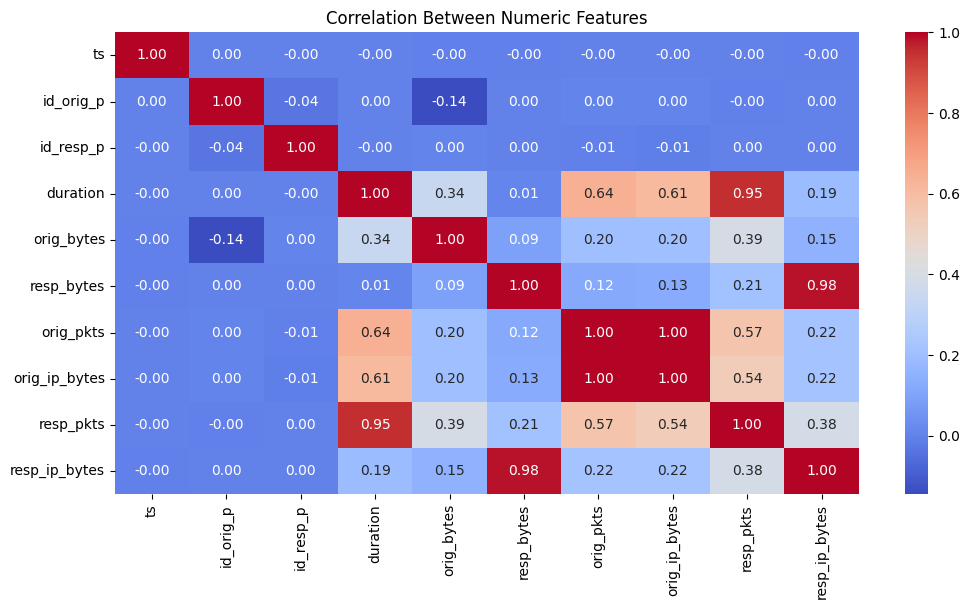

In [ ]:
# numerical cols
numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

# Convert PySpark DataFrame to pandas DataFrame for correlation calculation
pandas_df = df.select(numeric_cols).toPandas()

# Plot correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pandas_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

From the correlation matrix, it can be seen that:
1. Strong Positive Correlation (Close to 1.0)
  - `orig_pkts` and `orig_ip_bytes` are perfectly correlated (1.00), suggesting that packet count and total IP bytes from the origin are directly proportional. One of the variables could be dropped to reduce redundancy.
  - `resp_bytes` and `resp_ip_bytes` are similarly strongly correlated (0.98). This could also mean one of the columns might be redundant.
  - `duration` and `resp_pkts` are also strongly correlated (0.95). This makes sense as longer durations correlate with more response packets, indicating sustained communication during the duration.
2. Weak/Negligible Correlations (Close to 0):
  - Port numbers (`id.orig_p`, `id.resp_p`) have near-zero correlations with other features suggesting that ports do not directly influence traffic metrics (e.g. duration, bytes). This is expected as ports are identifiers, not quantitative measures.
  - Except for its strong positive correlation to `resp_ip_bytes`, `resp_bytes` and most other features have weak/negligible correlations (0.00-0.21) possibly indicating isolated response behaviors.

## Mutual Information Scoring

In [33]:
# Discretise numerical features
numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

# compute mutual info
def compute_mutual_info(df, feature_col, target_col="label", n_bins=5):
    # 5 quantile based bins per numerical col
    if feature_col in numeric_cols:
        df = df.withColumn(
            f"{feature_col}_bin",
            F.ntile(n_bins).over(Window.orderBy(feature_col)))
        feature_col = f"{feature_col}_bin"

    # Compute joint probability P(X,Y)
    joint_prob = (
        df.groupBy(feature_col, target_col)
        .agg(F.count("*").alias("count"))
        .withColumn("p_xy", F.col("count") / df.count())
    )

    # Compute marginal probabilities P(X) and P(Y)
    p_x = joint_prob.groupBy(feature_col).agg(F.sum("p_xy").alias("p_x"))
    p_y = joint_prob.groupBy(target_col).agg(F.sum("p_xy").alias("p_y"))

    # Calculate MI terms: p_xy * log2(p_xy / (p_x * p_y))
    mi_terms = (
        joint_prob.join(p_x, feature_col)
        .join(p_y, target_col)
        .withColumn(
            "mi_term",
            F.col("p_xy") * F.log2(F.col("p_xy") / (F.col("p_x") * F.col("p_y")))
        )
    )

    # Sum MI terms to get final score
    mi = mi_terms.agg(F.sum("mi_term").alias("mi")).collect()[0]["mi"]
    return float(mi) if mi else 0.0

# Compute MI for all features
df_mis = df.select("*")
mi_results = {}

for feature in df_mis.columns:  # Combine all features
    if feature == "label":
        continue
    mi_score = compute_mutual_info(df_mis, feature)
    mi_results[feature] = mi_score
    print(f"MI for {feature}: {mi_score:.4f}")

# Sort the MI and display results
sorted_mi_results = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)
print("\n=== Features sorted by Mutual Information ===")
for feature, mi_score in sorted_mi_results:
    print(f"{feature}: {mi_score:.4f}")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\jessi\AppData\Local\Programs\Python\Python313\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\jessi\AppData\Local\Programs\Python\Python313\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\jessi\AppData\Local\Programs\Python\Python313\Lib\socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

**Interpretation of Mutual Information (MI) Scoring:**

MI scoring is a measure of how much information one variable (feature) provides about another (target variable, in this case, `label`). It helps identify which features are most relevant for predicting the target, where a higher MI score means the feature is more informative for the prediction and should be prioritised for model training.

From the results:
The top 5 informative features are
1. `uid` (0.0282)
2. `id_resp_h` (0.0278)
3. `conn_state` (0.0230)
4. `history` (0.0176)
5. `proto` (0.0116)

On the other hand, the features with low/zero MI score are `resp_bytes` (0.0004) and `ts` (0.0007) which have very low MI and may have a negligible effect on prediction.

**Data Leakage Issue**

While `uid` has a high MI score, it could suggest that the `uid` is leaking information about the `label` as `uid` is supposed to be a unique identifier for the connection. Since it is unique per row, it has zero predictive power on new data and cannot be generalised onto new samples. This could cause the model to perform extremely well on training data but fail on unseen data.

## Anomaly detection (optional?)
KMeans

In [ ]:
# numeric cols
numeric_cols = [col_name for col_name, dtype in df.dtypes
                if dtype in ['int', 'double', 'float']]

print("KMeans using numeric columns:", numeric_cols)
kmeans_df = df.select(numeric_cols)

# kmeans cannot be done with NaN values
kmeans_df = kmeans_df.dropna()

# convert features to vector
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="unscaled_features"
)

scaler = StandardScaler(
    inputCol="unscaled_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Start with 5 clusters (adjust based on data)
kmeans = KMeans(
    k=5,
    seed=42,
    featuresCol="features",
    predictionCol="cluster"
)

pipeline = Pipeline(stages=[assembler, scaler, kmeans])
kmeans_model = pipeline.fit(kmeans_df)
kmeans_transformed = kmeans_model.transform(kmeans_df)

print("Calculating distance...")
# euclidean distance from point to centroid
centers = kmeans_model.stages[-1].clusterCenters()
udf_distance = udf(lambda v, c: float(np.linalg.norm(v - centers[c])), FloatType())
df_anomalies = kmeans_transformed.withColumn(
    "distance",
    udf_distance("features", "cluster")
)

# find anomalies (top 5% farthest points)
threshold = df_anomalies.approxQuantile("distance", [0.95], 0.01)[0] # 5%
anomalies = df_anomalies.filter(F.col("distance") >= threshold)

print(f"Found {anomalies.count()} anomalies (distance threshold: {threshold:.2f})")
print("\nSample anomalies:")
anomalies.select(numeric_cols + ["cluster", "distance"]).show(5)

KMeans using numeric columns: ['ts', 'id_orig_p', 'id_resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']
Calculating distance...
Found 171983 anomalies (distance threshold: 1.92)

Sample anomalies:
+-------------------+---------+---------+--------+----------+----------+---------+-------------+---------+-------------+-------+---------+
|                 ts|id_orig_p|id_resp_p|duration|orig_bytes|resp_bytes|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|cluster| distance|
+-------------------+---------+---------+--------+----------+----------+---------+-------------+---------+-------------+-------+---------+
|1.551377734188184E9|  52724.0|     80.0|1.978591|     149.0|  119442.0|    174.0|      11698.0|    172.0|     247844.0|      2| 957.9369|
|1.551377736206261E9|  52726.0|     80.0|2.182247|     149.0|  119442.0|    172.0|      11570.0|    170.0|     247740.0|      2| 957.4141|
|1.551377738426746E9|  52728.0|     80.0| 1.67555

In [ ]:
print("\nSample anomalies:")
anomalies.select(numeric_cols + ["cluster", "distance"]).show()


Sample anomalies:
+-------------------+---------+---------+--------+----------+----------+---------+-------------+---------+-------------+-------+---------+
|                 ts|id_orig_p|id_resp_p|duration|orig_bytes|resp_bytes|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|cluster| distance|
+-------------------+---------+---------+--------+----------+----------+---------+-------------+---------+-------------+-------+---------+
|1.551377734188184E9|  52724.0|     80.0|1.978591|     149.0|  119442.0|    174.0|      11698.0|    172.0|     247844.0|      2| 957.9369|
|1.551377736206261E9|  52726.0|     80.0|2.182247|     149.0|  119442.0|    172.0|      11570.0|    170.0|     247740.0|      2| 957.4141|
|1.551377738426746E9|  52728.0|     80.0| 1.67555|     152.0|   83118.0|    124.0|       8120.0|    122.0|     172596.0|      2|667.61676|
| 1.55137774014002E9|  52730.0|     80.0|1.798966|     149.0|   88797.0|    136.0|       8578.0|    134.0|     193266.0|      2|729.86896|
|1.55137

**Interpretation of KMeans**


### Checking for Distribution of Data Set

In [37]:
# Register DataFrame as a SQL table
df.createOrReplaceTempView("malware_data")

# Define SQL Query to count the number of rows with 0 and 1 in the target variable
query = """
SELECT
    label,
    COUNT(*) AS count
FROM
    malware_data
GROUP BY
    label
"""

# Run the SQL query
result = spark.sql(query)
result.show()

+------------------+-------+
|             label|  count|
+------------------+-------+
|            Benign|4108340|
|   Malicious   C&C|     33|
|Malicious   Attack|      3|
|  Malicious   DDoS|1906796|
+------------------+-------+



Very imbalance -> either undersample or can use class weights if we are doing random forests?

In [38]:
from pyspark.sql.functions import countDistinct

# Count distinct values for each column
cardinality = df.select(
    countDistinct("id_orig_h").alias("id_orig_h_cardinality"),
    countDistinct("id_orig_p").alias("id_orig_p_cardinality"),
    countDistinct("id_resp_h").alias("id_resp_h_cardinality"),
    countDistinct("id_resp_p").alias("id_resp_p_cardinality")
).collect()[0]

# Print the cardinality of each column
print(f"Cardinality of id_orig_h: {cardinality['id_orig_h_cardinality']}")
print(f"Cardinality of id_orig_p: {cardinality['id_orig_p_cardinality']}")
print(f"Cardinality of id_resp_h: {cardinality['id_resp_h_cardinality']}")
print(f"Cardinality of id_resp_p: {cardinality['id_resp_p_cardinality']}")

Cardinality of id_orig_h: 28
Cardinality of id_orig_p: 65536
Cardinality of id_resp_h: 4098969
Cardinality of id_resp_p: 16


cardinality of id_orig_h and id_resp_p are relatively lower -> 28 and 16 respectively. so we can one-hot encode them 

While the raw features alone have low MI, they might become highly predictive when combined.


Justification of new features:

`byte_ratio` measures the imbalance of bytes from origin. Malware often involves asymmetric communication. While `orig_byte` and `resp_byte` on their own tell you how much data was transferred, the ratio highlights how one-sided the connection was.

`pkt_ratio`, similar to `byte_ratio`, reveals asymmetry in the number of packets sent and received. Malware often sends small, repeated packets to beacon a command-and-control server, or floods a target with packets in a denial-of-service (DoS) attempt. The pkt_ratio highlights when one side is communicating heavily while the other side is silent.

`total_bytes` captures the entire volume of data transfered in a session, regardless of direction. Malware connections often falls into two extremes: tiny (beaconing, probes)/massive (data exfiltration/ large payload downloads). orig_byte or resp_byte alone may miss the full picture.

`total_pkts` represents the total number of packets in a session, which is a good indicator of connection length and complexity. Sessions with very few packets (e.g., 1–2) often represent failed probes, scans, or SYN floods, while very high packet counts may be large downloads or long-lived command-and-control sessions. Unlike raw orig_pkts or resp_pkts, total_pkts offers a complete snapshot of the interaction.

`throughput` measures the speed at which data is transferred (bytes transmitted per second). Malware often works in bursts, transferring large amounts of data very quickly before terminating. Raw duration or byte counts alone don’t reflect this dynamic. A short session with high data volume will be flagged clearly by throughput, making it a powerful feature for identifying fast, high-impact malicious events like exfiltration or rapid payload drops.

`efficiency` captures the average data transferred per packet, which helps distinguish between legitimate data transfers (like a file download with fewer, larger packets) and suspicious communication (like malware beaconing with many small packets). Neither total_bytes nor total_pkts alone captures this nuance. This feature condenses that relationship into a single metric that reflects communication style, which is especially useful for detecting stealthy malware.


Other high MI raw features included in the model:

Proto (TCP, UDP, ICMP) -> malware may prefer UDP or use less common protocols -> TCP more secure

Conn_state (connection status, successful, failed or reset) -> states like S0, RSTO, or REJ ma be common in faulted/malicious connections

History (sequence of events) -> can be very useful but string tho how to analyse? (understand it more) -> group rare categories under history into 1 category below 10 then one hot encoding.

### Checking for Cardinality of uids

In [39]:
from pyspark.sql.functions import countDistinct

# Count distinct values for each column
cardinality = df.select(
    countDistinct("id_orig_h").alias("id_orig_h_cardinality"),
    countDistinct("id_orig_p").alias("id_orig_p_cardinality"),
    countDistinct("id_resp_h").alias("id_resp_h_cardinality"),
    countDistinct("id_resp_p").alias("id_resp_p_cardinality")
).collect()[0]

# Print the cardinality of each column
print(f"Cardinality of id_orig_h: {cardinality['id_orig_h_cardinality']}")
print(f"Cardinality of id_orig_p: {cardinality['id_orig_p_cardinality']}")
print(f"Cardinality of id_resp_h: {cardinality['id_resp_h_cardinality']}")
print(f"Cardinality of id_resp_p: {cardinality['id_resp_p_cardinality']}")


Cardinality of id_orig_h: 28
Cardinality of id_orig_p: 65536
Cardinality of id_resp_h: 4098969
Cardinality of id_resp_p: 16


id_orig_h has low cardinality -> 28 so likely represent small number of internal source IPs (devices on your network)

id_resp_p has low cardinality -> destination ports, likely standard ones like 80, 443, 22. tells you what kind of service was accessed. 

Feature Engineering

New Meaningful Features

In [40]:
from pyspark.sql.functions import count

## Frequency Encoding of High Cardinality Features such as History

# Calculate frequency counts for each category in the 'history' column
history_counts = df.groupBy("history").agg(count("*").alias("history_count"))

# Join the frequency counts back to the original DataFrame
df = df.join(history_counts, "history", "left")

# Create a new column 'history_freq_encoded' with the frequency counts
df = df.withColumn("history_freq_encoded", col("history_count"))

# Optionally drop the intermediate 'history_count' column
df = df.drop("history_count")

# Show the DataFrame with the frequency encoded column
df.select("history", "history_freq_encoded").show()




+-------+--------------------+
|history|history_freq_encoded|
+-------+--------------------+
| DdAaFf|                   1|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|      D|                1086|
|     Dd|                 659|
|     Dd|                 659|
|     Dd|                 659|
|     Dd|                 659|
|     Dd|                 659|
|     Dd|                 659|
|     Dd|                 659|
|      S|             4104511|
|      S|             4104511|
+-------+--------------------+
only showing top 20 rows



Encoding of Categorical Variables:

In [41]:
from pyspark.sql.functions import col, when, lit, log1p

# Total Bytes
df = df.withColumn("total_bytes", col("orig_bytes") + col("resp_bytes"))

# Byte Ratio (orig_bytes / (resp_bytes + 1))
df = df.withColumn("byte_ratio", col("orig_bytes") / (col("resp_bytes") + lit(1)))

# Packet Ratio (orig_pkts / (resp_pkts + 1))
df = df.withColumn("pkt_ratio", col("orig_pkts") / (col("resp_pkts") + lit(1)))

# Total Packet Count
df = df.withColumn("total_pkts", col("orig_pkts") + col("resp_pkts"))

# Throughput = total_bytes / (duration + 1e-6)
df = df.withColumn("throughput", col("total_bytes") / (col("duration") + lit(1e-6)))

# Data-to-packet efficiency
df = df.withColumn("efficiency", col("total_bytes") / (col("total_pkts") + lit(1)))

df.select("total_bytes", "byte_ratio", "throughput", "is_asymmetric").show(5)


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `is_asymmetric` cannot be resolved. Did you mean one of the following? [`history`, `label`, `resp_bytes`, `resp_pkts`, `byte_ratio`].;
'Project [total_bytes#4381, byte_ratio#4402, throughput#4471, 'is_asymmetric]
+- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_freq_encoded#4320L, total_bytes#4381, byte_ratio#4402, pkt_ratio#4424, total_pkts#4447, throughput#4471, (cast(total_bytes#4381 as double) / cast((total_pkts#4447 + cast(1 as float)) as double)) AS efficiency#4496]
   +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_freq_encoded#4320L, total_bytes#4381, byte_ratio#4402, pkt_ratio#4424, total_pkts#4447, (cast(total_bytes#4381 as double) / cast((cast(duration#3906 as double) + 1.0E-6) as double)) AS throughput#4471]
      +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_freq_encoded#4320L, total_bytes#4381, byte_ratio#4402, pkt_ratio#4424, (orig_pkts#1154 + resp_pkts#1202) AS total_pkts#4447]
         +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_freq_encoded#4320L, total_bytes#4381, byte_ratio#4402, (cast(orig_pkts#1154 as double) / cast((resp_pkts#1202 + cast(1 as float)) as double)) AS pkt_ratio#4424]
            +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_freq_encoded#4320L, total_bytes#4381, (cast(orig_bytes#3925 as double) / cast((resp_bytes#3944 + cast(1 as float)) as double)) AS byte_ratio#4402]
               +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_freq_encoded#4320L, (orig_bytes#3925 + resp_bytes#3944) AS total_bytes#4381]
                  +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_freq_encoded#4320L]
                     +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_count#4251L, history_count#4251L AS history_freq_encoded#4320L]
                        +- Project [history#863, ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, resp_bytes#3944, conn_state#859, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870, history_count#4251L]
                           +- Join LeftOuter, (history#863 = history#4292)
                              :- Filter atleastnnonnulls(3, duration#3906, orig_bytes#3925, resp_bytes#3944)
                              :  +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, orig_bytes#3925, CASE WHEN ((resp_bytes#3725 = cast(NULL as float)) OR (resp_bytes#3725 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#3725 END AS resp_bytes#3944, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :     +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3906, CASE WHEN ((orig_bytes#3706 = cast(NULL as float)) OR (orig_bytes#3706 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#3706 END AS orig_bytes#3925, resp_bytes#3725, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :        +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, CASE WHEN ((duration#3687 = cast(NULL as float)) OR (duration#3687 = cast(null as float))) THEN cast(null as float) ELSE duration#3687 END AS duration#3906, orig_bytes#3706, resp_bytes#3725, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :           +- Filter atleastnnonnulls(3, duration#3687, orig_bytes#3706, resp_bytes#3725)
                              :              +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3687, orig_bytes#3706, CASE WHEN ((resp_bytes#3304 = cast(NULL as float)) OR (resp_bytes#3304 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#3304 END AS resp_bytes#3725, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                 +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3687, CASE WHEN ((orig_bytes#3285 = cast(NULL as float)) OR (orig_bytes#3285 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#3285 END AS orig_bytes#3706, resp_bytes#3304, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                    +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, CASE WHEN ((duration#3266 = cast(NULL as float)) OR (duration#3266 = cast(null as float))) THEN cast(null as float) ELSE duration#3266 END AS duration#3687, orig_bytes#3285, resp_bytes#3304, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                       +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3266, orig_bytes#3285, cast(resp_bytes#3208 as float) AS resp_bytes#3304, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                          +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, duration#3266, cast(orig_bytes#3189 as float) AS orig_bytes#3285, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                             +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, id_resp_p#3247, proto#854, cast(duration#3170 as float) AS duration#3266, orig_bytes#3189, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3228, id_resp_h#852, cast(id_resp_p#3151 as float) AS id_resp_p#3247, proto#854, duration#3170, orig_bytes#3189, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                   +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#3132 as float) AS id_orig_p#3228, id_resp_h#852, id_resp_p#3151, proto#854, duration#3170, orig_bytes#3189, resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                      +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, id_resp_p#3151, proto#854, duration#3170, orig_bytes#3189, cast(resp_bytes#2951 as float) AS resp_bytes#3208, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                         +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, id_resp_p#3151, proto#854, duration#3170, cast(orig_bytes#2932 as float) AS orig_bytes#3189, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                            +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, id_resp_p#3151, proto#854, cast(duration#2913 as float) AS duration#3170, orig_bytes#2932, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                               +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#3132, id_resp_h#852, cast(id_resp_p#2653 as float) AS id_resp_p#3151, proto#854, duration#2913, orig_bytes#2932, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                  +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#2634 as float) AS id_orig_p#3132, id_resp_h#852, id_resp_p#2653, proto#854, duration#2913, orig_bytes#2932, resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                     +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2913, orig_bytes#2932, CASE WHEN ((resp_bytes#2876 = cast(NULL as float)) OR (resp_bytes#2876 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#2876 END AS resp_bytes#2951, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                        +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2913, CASE WHEN ((orig_bytes#2857 = cast(NULL as float)) OR (orig_bytes#2857 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#2857 END AS orig_bytes#2932, resp_bytes#2876, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                           +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, CASE WHEN ((duration#2838 = cast(NULL as float)) OR (duration#2838 = cast(null as float))) THEN cast(null as float) ELSE duration#2838 END AS duration#2913, orig_bytes#2857, resp_bytes#2876, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                              +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2838, orig_bytes#2857, CASE WHEN ((resp_bytes#2710 = cast(NULL as float)) OR (resp_bytes#2710 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#2710 END AS resp_bytes#2876, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                 +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2838, CASE WHEN ((orig_bytes#2691 = cast(NULL as float)) OR (orig_bytes#2691 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#2691 END AS orig_bytes#2857, resp_bytes#2710, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                    +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, CASE WHEN ((duration#2672 = cast(NULL as float)) OR (duration#2672 = cast(null as float))) THEN cast(null as float) ELSE duration#2672 END AS duration#2838, orig_bytes#2691, resp_bytes#2710, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                       +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2672, orig_bytes#2691, cast(resp_bytes#2614 as float) AS resp_bytes#2710, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                          +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, duration#2672, cast(orig_bytes#2595 as float) AS orig_bytes#2691, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                             +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, id_resp_p#2653, proto#854, cast(duration#2576 as float) AS duration#2672, orig_bytes#2595, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                                +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#2634, id_resp_h#852, cast(id_resp_p#1034 as float) AS id_resp_p#2653, proto#854, duration#2576, orig_bytes#2595, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                                   +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#1010 as float) AS id_orig_p#2634, id_resp_h#852, id_resp_p#1034, proto#854, duration#2576, orig_bytes#2595, resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                                      +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, duration#2576, orig_bytes#2595, cast(resp_bytes#1106 as float) AS resp_bytes#2614, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                                         +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, duration#2576, cast(orig_bytes#1082 as float) AS orig_bytes#2595, resp_bytes#1106, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                                            +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, cast(duration#1058 as float) AS duration#2576, orig_bytes#1082, resp_bytes#1106, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                                               +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#869, detailed-label#870]
                              :                                                                                                  +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, cast(resp_ip_bytes#867 as float) AS resp_ip_bytes#1226, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                     +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, orig_pkts#1154, orig_ip_bytes#1178, cast(resp_pkts#866 as float) AS resp_pkts#1202, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                        +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, orig_pkts#1154, cast(orig_ip_bytes#865 as float) AS orig_ip_bytes#1178, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                           +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#1130, history#863, cast(orig_pkts#864 as float) AS orig_pkts#1154, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                              +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, cast(missed_bytes#862 as float) AS missed_bytes#1130, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                                 +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, orig_bytes#1082, cast(resp_bytes#858 as float) AS resp_bytes#1106, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                                    +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, duration#1058, cast(orig_bytes#857 as float) AS orig_bytes#1082, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                                       +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, id_resp_p#1034, proto#854, service#855, cast(duration#856 as float) AS duration#1058, orig_bytes#857, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                                          +- Project [ts#848, uid#849, id_orig_h#850, id_orig_p#1010, id_resp_h#852, cast(id_resp_p#853 as float) AS id_resp_p#1034, proto#854, service#855, duration#856, orig_bytes#857, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                                             +- Project [ts#848, uid#849, id_orig_h#850, cast(id_orig_p#851 as float) AS id_orig_p#1010, id_resp_h#852, id_resp_p#853, proto#854, service#855, duration#856, orig_bytes#857, resp_bytes#858, conn_state#859, local_orig#860, local_resp#861, missed_bytes#862, history#863, orig_pkts#864, orig_ip_bytes#865, resp_pkts#866, resp_ip_bytes#867, tunnel_parents#868, label#869, detailed-label#870]
                              :                                                                                                                                +- Project [ts#296 AS ts#848, uid#320 AS uid#849, id.orig_h#344 AS id_orig_h#850, id.orig_p#368 AS id_orig_p#851, id.resp_h#392 AS id_resp_h#852, id.resp_p#416 AS id_resp_p#853, proto#440 AS proto#854, service#464 AS service#855, duration#488 AS duration#856, orig_bytes#512 AS orig_bytes#857, resp_bytes#536 AS resp_bytes#858, conn_state#560 AS conn_state#859, local_orig#584 AS local_orig#860, local_resp#608 AS local_resp#861, missed_bytes#632 AS missed_bytes#862, history#656 AS history#863, orig_pkts#680 AS orig_pkts#864, orig_ip_bytes#704 AS orig_ip_bytes#865, resp_pkts#728 AS resp_pkts#866, resp_ip_bytes#752 AS resp_ip_bytes#867, tunnel_parents#776 AS tunnel_parents#868, label#800 AS label#869, detailed-label#824 AS detailed-label#870]
                              :                                                                                                                                   +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, tunnel_parents#776, label#800, CASE WHEN (detailed-label#39 = -) THEN cast(null as string) ELSE detailed-label#39 END AS detailed-label#824]
                              :                                                                                                                                      +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, tunnel_parents#776, CASE WHEN (label#38 = -) THEN cast(null as string) ELSE label#38 END AS label#800, detailed-label#39]
                              :                                                                                                                                         +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, CASE WHEN (tunnel_parents#37 = -) THEN cast(null as string) ELSE tunnel_parents#37 END AS tunnel_parents#776, label#38, detailed-label#39]
                              :                                                                                                                                            +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, CASE WHEN (resp_ip_bytes#36 = cast(- as double)) THEN cast(null as double) ELSE resp_ip_bytes#36 END AS resp_ip_bytes#752, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                               +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, CASE WHEN (resp_pkts#35 = cast(- as double)) THEN cast(null as double) ELSE resp_pkts#35 END AS resp_pkts#728, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                  +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, CASE WHEN (orig_ip_bytes#34 = cast(- as double)) THEN cast(null as double) ELSE orig_ip_bytes#34 END AS orig_ip_bytes#704, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                     +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, CASE WHEN (orig_pkts#33 = cast(- as double)) THEN cast(null as double) ELSE orig_pkts#33 END AS orig_pkts#680, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                        +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, CASE WHEN (history#32 = -) THEN cast(null as string) ELSE history#32 END AS history#656, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                           +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, CASE WHEN (missed_bytes#31 = cast(- as double)) THEN cast(null as double) ELSE missed_bytes#31 END AS missed_bytes#632, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                              +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, CASE WHEN (local_resp#30 = -) THEN cast(null as string) ELSE local_resp#30 END AS local_resp#608, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                 +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, CASE WHEN (local_orig#29 = -) THEN cast(null as string) ELSE local_orig#29 END AS local_orig#584, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                    +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, CASE WHEN (conn_state#28 = -) THEN cast(null as string) ELSE conn_state#28 END AS conn_state#560, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                       +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, CASE WHEN (resp_bytes#27 = -) THEN cast(null as string) ELSE resp_bytes#27 END AS resp_bytes#536, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                          +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, CASE WHEN (orig_bytes#26 = -) THEN cast(null as string) ELSE orig_bytes#26 END AS orig_bytes#512, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                             +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, CASE WHEN (duration#25 = -) THEN cast(null as string) ELSE duration#25 END AS duration#488, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, CASE WHEN (service#24 = -) THEN cast(null as string) ELSE service#24 END AS service#464, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                   +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, CASE WHEN (proto#23 = -) THEN cast(null as string) ELSE proto#23 END AS proto#440, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                      +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, CASE WHEN (id.resp_p#22 = cast(- as double)) THEN cast(null as double) ELSE id.resp_p#22 END AS id.resp_p#416, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                         +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, CASE WHEN (id.resp_h#21 = -) THEN cast(null as string) ELSE id.resp_h#21 END AS id.resp_h#392, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                            +- Project [ts#296, uid#320, id.orig_h#344, CASE WHEN (id.orig_p#20 = cast(- as double)) THEN cast(null as double) ELSE id.orig_p#20 END AS id.orig_p#368, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                               +- Project [ts#296, uid#320, CASE WHEN (id.orig_h#19 = -) THEN cast(null as string) ELSE id.orig_h#19 END AS id.orig_h#344, id.orig_p#20, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                                  +- Project [ts#296, CASE WHEN (uid#18 = -) THEN cast(null as string) ELSE uid#18 END AS uid#320, id.orig_h#19, id.orig_p#20, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                                     +- Project [CASE WHEN (ts#17 = cast(- as double)) THEN cast(null as double) ELSE ts#17 END AS ts#296, uid#18, id.orig_h#19, id.orig_p#20, id.resp_h#21, id.resp_p#22, proto#23, service#24, duration#25, orig_bytes#26, resp_bytes#27, conn_state#28, local_orig#29, local_resp#30, missed_bytes#31, history#32, orig_pkts#33, orig_ip_bytes#34, resp_pkts#35, resp_ip_bytes#36, tunnel_parents#37, label#38, detailed-label#39]
                              :                                                                                                                                                                                                        +- Relation [ts#17,uid#18,id.orig_h#19,id.orig_p#20,id.resp_h#21,id.resp_p#22,proto#23,service#24,duration#25,orig_bytes#26,resp_bytes#27,conn_state#28,local_orig#29,local_resp#30,missed_bytes#31,history#32,orig_pkts#33,orig_ip_bytes#34,resp_pkts#35,resp_ip_bytes#36,tunnel_parents#37,label#38,detailed-label#39] csv
                              +- Aggregate [history#4292], [history#4292, count(1) AS history_count#4251L]
                                 +- Filter atleastnnonnulls(3, duration#3906, orig_bytes#3925, resp_bytes#3944)
                                    +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, duration#3906, orig_bytes#3925, CASE WHEN ((resp_bytes#3725 = cast(NULL as float)) OR (resp_bytes#3725 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#3725 END AS resp_bytes#3944, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                       +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, duration#3906, CASE WHEN ((orig_bytes#3706 = cast(NULL as float)) OR (orig_bytes#3706 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#3706 END AS orig_bytes#3925, resp_bytes#3725, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                          +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, CASE WHEN ((duration#3687 = cast(NULL as float)) OR (duration#3687 = cast(null as float))) THEN cast(null as float) ELSE duration#3687 END AS duration#3906, orig_bytes#3706, resp_bytes#3725, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                             +- Filter atleastnnonnulls(3, duration#3687, orig_bytes#3706, resp_bytes#3725)
                                                +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, duration#3687, orig_bytes#3706, CASE WHEN ((resp_bytes#3304 = cast(NULL as float)) OR (resp_bytes#3304 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#3304 END AS resp_bytes#3725, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                   +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, duration#3687, CASE WHEN ((orig_bytes#3285 = cast(NULL as float)) OR (orig_bytes#3285 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#3285 END AS orig_bytes#3706, resp_bytes#3304, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                      +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, CASE WHEN ((duration#3266 = cast(NULL as float)) OR (duration#3266 = cast(null as float))) THEN cast(null as float) ELSE duration#3266 END AS duration#3687, orig_bytes#3285, resp_bytes#3304, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                         +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, duration#3266, orig_bytes#3285, cast(resp_bytes#3208 as float) AS resp_bytes#3304, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                            +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, duration#3266, cast(orig_bytes#3189 as float) AS orig_bytes#3285, resp_bytes#3208, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                               +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, id_resp_p#3247, proto#4283, cast(duration#3170 as float) AS duration#3266, orig_bytes#3189, resp_bytes#3208, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                  +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3228, id_resp_h#4281, cast(id_resp_p#3151 as float) AS id_resp_p#3247, proto#4283, duration#3170, orig_bytes#3189, resp_bytes#3208, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                     +- Project [ts#4277, uid#4278, id_orig_h#4279, cast(id_orig_p#3132 as float) AS id_orig_p#3228, id_resp_h#4281, id_resp_p#3151, proto#4283, duration#3170, orig_bytes#3189, resp_bytes#3208, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                        +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3132, id_resp_h#4281, id_resp_p#3151, proto#4283, duration#3170, orig_bytes#3189, cast(resp_bytes#2951 as float) AS resp_bytes#3208, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                           +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3132, id_resp_h#4281, id_resp_p#3151, proto#4283, duration#3170, cast(orig_bytes#2932 as float) AS orig_bytes#3189, resp_bytes#2951, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                              +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3132, id_resp_h#4281, id_resp_p#3151, proto#4283, cast(duration#2913 as float) AS duration#3170, orig_bytes#2932, resp_bytes#2951, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                 +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#3132, id_resp_h#4281, cast(id_resp_p#2653 as float) AS id_resp_p#3151, proto#4283, duration#2913, orig_bytes#2932, resp_bytes#2951, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                    +- Project [ts#4277, uid#4278, id_orig_h#4279, cast(id_orig_p#2634 as float) AS id_orig_p#3132, id_resp_h#4281, id_resp_p#2653, proto#4283, duration#2913, orig_bytes#2932, resp_bytes#2951, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                       +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, duration#2913, orig_bytes#2932, CASE WHEN ((resp_bytes#2876 = cast(NULL as float)) OR (resp_bytes#2876 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#2876 END AS resp_bytes#2951, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                          +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, duration#2913, CASE WHEN ((orig_bytes#2857 = cast(NULL as float)) OR (orig_bytes#2857 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#2857 END AS orig_bytes#2932, resp_bytes#2876, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                             +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, CASE WHEN ((duration#2838 = cast(NULL as float)) OR (duration#2838 = cast(null as float))) THEN cast(null as float) ELSE duration#2838 END AS duration#2913, orig_bytes#2857, resp_bytes#2876, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, duration#2838, orig_bytes#2857, CASE WHEN ((resp_bytes#2710 = cast(NULL as float)) OR (resp_bytes#2710 = cast(null as float))) THEN cast(null as float) ELSE resp_bytes#2710 END AS resp_bytes#2876, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                   +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, duration#2838, CASE WHEN ((orig_bytes#2691 = cast(NULL as float)) OR (orig_bytes#2691 = cast(null as float))) THEN cast(null as float) ELSE orig_bytes#2691 END AS orig_bytes#2857, resp_bytes#2710, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                      +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, CASE WHEN ((duration#2672 = cast(NULL as float)) OR (duration#2672 = cast(null as float))) THEN cast(null as float) ELSE duration#2672 END AS duration#2838, orig_bytes#2691, resp_bytes#2710, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                         +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, duration#2672, orig_bytes#2691, cast(resp_bytes#2614 as float) AS resp_bytes#2710, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                            +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, duration#2672, cast(orig_bytes#2595 as float) AS orig_bytes#2691, resp_bytes#2614, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                               +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, id_resp_p#2653, proto#4283, cast(duration#2576 as float) AS duration#2672, orig_bytes#2595, resp_bytes#2614, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                                  +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#2634, id_resp_h#4281, cast(id_resp_p#1034 as float) AS id_resp_p#2653, proto#4283, duration#2576, orig_bytes#2595, resp_bytes#2614, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                                     +- Project [ts#4277, uid#4278, id_orig_h#4279, cast(id_orig_p#1010 as float) AS id_orig_p#2634, id_resp_h#4281, id_resp_p#1034, proto#4283, duration#2576, orig_bytes#2595, resp_bytes#2614, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                                        +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, duration#2576, orig_bytes#2595, cast(resp_bytes#1106 as float) AS resp_bytes#2614, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                                           +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, duration#2576, cast(orig_bytes#1082 as float) AS orig_bytes#2595, resp_bytes#1106, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                                              +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, cast(duration#1058 as float) AS duration#2576, orig_bytes#1082, resp_bytes#1106, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                                                 +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#4288, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, resp_ip_bytes#1226, label#4298, detailed-label#4299]
                                                                                                                                    +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#1130, history#4292, orig_pkts#1154, orig_ip_bytes#1178, resp_pkts#1202, cast(resp_ip_bytes#4296 as float) AS resp_ip_bytes#1226, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                       +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#1130, history#4292, orig_pkts#1154, orig_ip_bytes#1178, cast(resp_pkts#4295 as float) AS resp_pkts#1202, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                          +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#1130, history#4292, orig_pkts#1154, cast(orig_ip_bytes#4294 as float) AS orig_ip_bytes#1178, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                             +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#1130, history#4292, cast(orig_pkts#4293 as float) AS orig_pkts#1154, orig_ip_bytes#4294, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                                +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, duration#1058, orig_bytes#1082, resp_bytes#1106, conn_state#4288, local_orig#4289, local_resp#4290, cast(missed_bytes#4291 as float) AS missed_bytes#1130, history#4292, orig_pkts#4293, orig_ip_bytes#4294, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                                   +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, duration#1058, orig_bytes#1082, cast(resp_bytes#4287 as float) AS resp_bytes#1106, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#4291, history#4292, orig_pkts#4293, orig_ip_bytes#4294, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                                      +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, duration#1058, cast(orig_bytes#4286 as float) AS orig_bytes#1082, resp_bytes#4287, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#4291, history#4292, orig_pkts#4293, orig_ip_bytes#4294, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                                         +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, id_resp_p#1034, proto#4283, service#4284, cast(duration#4285 as float) AS duration#1058, orig_bytes#4286, resp_bytes#4287, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#4291, history#4292, orig_pkts#4293, orig_ip_bytes#4294, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                                            +- Project [ts#4277, uid#4278, id_orig_h#4279, id_orig_p#1010, id_resp_h#4281, cast(id_resp_p#4282 as float) AS id_resp_p#1034, proto#4283, service#4284, duration#4285, orig_bytes#4286, resp_bytes#4287, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#4291, history#4292, orig_pkts#4293, orig_ip_bytes#4294, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                                               +- Project [ts#4277, uid#4278, id_orig_h#4279, cast(id_orig_p#4280 as float) AS id_orig_p#1010, id_resp_h#4281, id_resp_p#4282, proto#4283, service#4284, duration#4285, orig_bytes#4286, resp_bytes#4287, conn_state#4288, local_orig#4289, local_resp#4290, missed_bytes#4291, history#4292, orig_pkts#4293, orig_ip_bytes#4294, resp_pkts#4295, resp_ip_bytes#4296, tunnel_parents#4297, label#4298, detailed-label#4299]
                                                                                                                                                                  +- Project [ts#296 AS ts#4277, uid#320 AS uid#4278, id.orig_h#344 AS id_orig_h#4279, id.orig_p#368 AS id_orig_p#4280, id.resp_h#392 AS id_resp_h#4281, id.resp_p#416 AS id_resp_p#4282, proto#440 AS proto#4283, service#464 AS service#4284, duration#488 AS duration#4285, orig_bytes#512 AS orig_bytes#4286, resp_bytes#536 AS resp_bytes#4287, conn_state#560 AS conn_state#4288, local_orig#584 AS local_orig#4289, local_resp#608 AS local_resp#4290, missed_bytes#632 AS missed_bytes#4291, history#656 AS history#4292, orig_pkts#680 AS orig_pkts#4293, orig_ip_bytes#704 AS orig_ip_bytes#4294, resp_pkts#728 AS resp_pkts#4295, resp_ip_bytes#752 AS resp_ip_bytes#4296, tunnel_parents#776 AS tunnel_parents#4297, label#800 AS label#4298, detailed-label#824 AS detailed-label#4299]
                                                                                                                                                                     +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, tunnel_parents#776, label#800, CASE WHEN (detailed-label#4276 = -) THEN cast(null as string) ELSE detailed-label#4276 END AS detailed-label#824]
                                                                                                                                                                        +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, tunnel_parents#776, CASE WHEN (label#4275 = -) THEN cast(null as string) ELSE label#4275 END AS label#800, detailed-label#4276]
                                                                                                                                                                           +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, resp_ip_bytes#752, CASE WHEN (tunnel_parents#4274 = -) THEN cast(null as string) ELSE tunnel_parents#4274 END AS tunnel_parents#776, label#4275, detailed-label#4276]
                                                                                                                                                                              +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, resp_pkts#728, CASE WHEN (resp_ip_bytes#4273 = cast(- as double)) THEN cast(null as double) ELSE resp_ip_bytes#4273 END AS resp_ip_bytes#752, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                 +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, orig_ip_bytes#704, CASE WHEN (resp_pkts#4272 = cast(- as double)) THEN cast(null as double) ELSE resp_pkts#4272 END AS resp_pkts#728, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                    +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, orig_pkts#680, CASE WHEN (orig_ip_bytes#4271 = cast(- as double)) THEN cast(null as double) ELSE orig_ip_bytes#4271 END AS orig_ip_bytes#704, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                       +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, history#656, CASE WHEN (orig_pkts#4270 = cast(- as double)) THEN cast(null as double) ELSE orig_pkts#4270 END AS orig_pkts#680, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                          +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, missed_bytes#632, CASE WHEN (history#4269 = -) THEN cast(null as string) ELSE history#4269 END AS history#656, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                             +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, local_resp#608, CASE WHEN (missed_bytes#4268 = cast(- as double)) THEN cast(null as double) ELSE missed_bytes#4268 END AS missed_bytes#632, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, local_orig#584, CASE WHEN (local_resp#4267 = -) THEN cast(null as string) ELSE local_resp#4267 END AS local_resp#608, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                   +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, conn_state#560, CASE WHEN (local_orig#4266 = -) THEN cast(null as string) ELSE local_orig#4266 END AS local_orig#584, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                      +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, resp_bytes#536, CASE WHEN (conn_state#4265 = -) THEN cast(null as string) ELSE conn_state#4265 END AS conn_state#560, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                         +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, orig_bytes#512, CASE WHEN (resp_bytes#4264 = -) THEN cast(null as string) ELSE resp_bytes#4264 END AS resp_bytes#536, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                            +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, duration#488, CASE WHEN (orig_bytes#4263 = -) THEN cast(null as string) ELSE orig_bytes#4263 END AS orig_bytes#512, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                               +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, service#464, CASE WHEN (duration#4262 = -) THEN cast(null as string) ELSE duration#4262 END AS duration#488, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                  +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, proto#440, CASE WHEN (service#4261 = -) THEN cast(null as string) ELSE service#4261 END AS service#464, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                     +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, id.resp_p#416, CASE WHEN (proto#4260 = -) THEN cast(null as string) ELSE proto#4260 END AS proto#440, service#4261, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                        +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, id.resp_h#392, CASE WHEN (id.resp_p#4259 = cast(- as double)) THEN cast(null as double) ELSE id.resp_p#4259 END AS id.resp_p#416, proto#4260, service#4261, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                           +- Project [ts#296, uid#320, id.orig_h#344, id.orig_p#368, CASE WHEN (id.resp_h#4258 = -) THEN cast(null as string) ELSE id.resp_h#4258 END AS id.resp_h#392, id.resp_p#4259, proto#4260, service#4261, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                              +- Project [ts#296, uid#320, id.orig_h#344, CASE WHEN (id.orig_p#4257 = cast(- as double)) THEN cast(null as double) ELSE id.orig_p#4257 END AS id.orig_p#368, id.resp_h#4258, id.resp_p#4259, proto#4260, service#4261, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                                 +- Project [ts#296, uid#320, CASE WHEN (id.orig_h#4256 = -) THEN cast(null as string) ELSE id.orig_h#4256 END AS id.orig_h#344, id.orig_p#4257, id.resp_h#4258, id.resp_p#4259, proto#4260, service#4261, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                                    +- Project [ts#296, CASE WHEN (uid#4255 = -) THEN cast(null as string) ELSE uid#4255 END AS uid#320, id.orig_h#4256, id.orig_p#4257, id.resp_h#4258, id.resp_p#4259, proto#4260, service#4261, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                                       +- Project [CASE WHEN (ts#4254 = cast(- as double)) THEN cast(null as double) ELSE ts#4254 END AS ts#296, uid#4255, id.orig_h#4256, id.orig_p#4257, id.resp_h#4258, id.resp_p#4259, proto#4260, service#4261, duration#4262, orig_bytes#4263, resp_bytes#4264, conn_state#4265, local_orig#4266, local_resp#4267, missed_bytes#4268, history#4269, orig_pkts#4270, orig_ip_bytes#4271, resp_pkts#4272, resp_ip_bytes#4273, tunnel_parents#4274, label#4275, detailed-label#4276]
                                                                                                                                                                                                                                          +- Relation [ts#4254,uid#4255,id.orig_h#4256,id.orig_p#4257,id.resp_h#4258,id.resp_p#4259,proto#4260,service#4261,duration#4262,orig_bytes#4263,resp_bytes#4264,conn_state#4265,local_orig#4266,local_resp#4267,missed_bytes#4268,history#4269,orig_pkts#4270,orig_ip_bytes#4271,resp_pkts#4272,resp_ip_bytes#4273,tunnel_parents#4274,label#4275,detailed-label#4276] csv
